# Fake News detection

# Fake News Classification Project

## Overview
This notebook demonstrates the process of building a machine learning model to classify news articles as fake or real. The dataset used in this project consists of articles with titles, text, authors, and labels indicating whether the news is fake or real. The project involves data preprocessing, text preprocessing (stemming), feature extraction using TF-IDF vectorization, model training, evaluation, and saving the best-performing model and vectorizer.

## Dataset
- `id`: Unique identifier for each article
- `title`: The title of the article
- `author`: The author of the article
- `text`: The main text of the article
- `label`: The label indicating whether the news is fake (1) or real (0)

## Steps Involved
1. **Data Preprocessing**:
   - Handling missing values
   - Combining `title` and `text` columns into a single `content` column
   - Dropping less important columns

2. **Text Preprocessing**:
   - Stemming: Reducing words to their root form to standardize the text

3. **Feature Extraction**:
   - Using `TfidfVectorizer` to convert text data into numerical features

4. **Model Training and Evaluation**:
   - Training multiple classifiers: Logistic Regression, Random Forest, Linear SVC, Decision Tree, and Gradient Boosting
   - Evaluating model performance using accuracy, confusion matrix, and classification report

5. **Model Saving**:
   - Saving the best-performing model and the vectorizer for future use

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from copy import deepcopy
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import os

In [2]:
# Download stopwords from nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Check downloaded stopwords in english
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

# Load Data

In [4]:
df_train = pd.read_csv('Prepare_model\\train.csv')
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
# Show shape of the dataset
df_train.shape

(20800, 5)

In [6]:
# Show some info about dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


# Data Preprocessing

In [7]:
# Take a copy from original training data
df_train_proc = deepcopy(df_train)

## Hanlding missing values

In [8]:
# Check about missing values to decide if we will make handling for it or not
df_train_proc.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [9]:
# Drop rows that contain at least one none value based on the title and text columns
df_train_proc = df_train_proc.dropna(subset=['title', 'text'])
df_train_proc.shape

(20203, 5)

In [10]:
# Check about none values after handling missing values
df_train_proc.isnull().sum()

id           0
title        0
author    1918
text         0
label        0
dtype: int64

## Handling invalid data

In [11]:
# Combine title and text columns into one column and their contents separated by colon
df_train_proc['content'] = df_train_proc['title'] + ': ' + df_train_proc['text']
df_train_proc.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired: Why the Tru...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [12]:
# Drop author column from dataset because it's less important to the predition process
df_train_proc = df_train_proc.drop(columns = ['author'])
df_train_proc.head()

,id,title,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired: Why the Tru...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


label
0    10387
1     9816
Name: count, dtype: int64


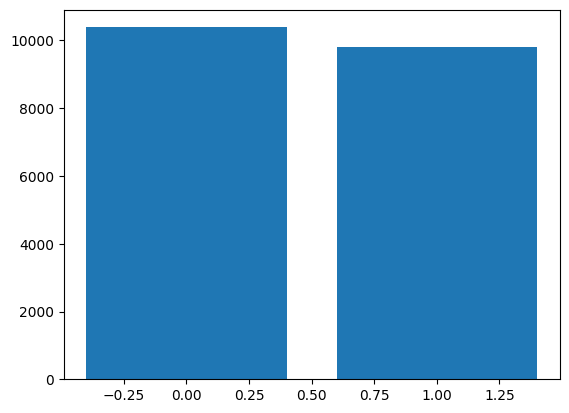

In [13]:
# Visualize label values to check about balancing of 0's and 1's
counts = df_train_proc['label'].value_counts()
print(counts)

# Plot result of each group
plt.bar(counts.index, counts)
plt.show()

In [14]:
# Show data input and label data after the preporcessing step has been finihsed
df_train_proc[['content', 'label']].head()

,content,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired: Why the Tru...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


## Split data into input and output data

In [15]:
# Split data into input and label data
X = df_train_proc['content']
Y = df_train_proc['label']
print(f'X shape {X.shape}, Y shape {Y.shape}')

X shape (20203,), Y shape (20203,)


## Stemming data

*stemming process: text preprocessing technique used in natural language processing (NLP) to reduce words to their root or base form. The main goal of stemming is to group together different forms of a word so they can be analyzed as a single item. This is especially useful in tasks like information retrieval and text mining.*

In [16]:
# Create porter stemmer to stemming data
stemmer = PorterStemmer()

In [17]:
# Create function to stem all words in the content
def stemming(content, stemmer):
    # Work on the alphabetical words only
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    
    # Convert sentences into lower case sentences
    stemmed_content = stemmed_content.lower()
    # Split sentences into words
    stemmed_content = stemmed_content.split()
    
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    # Stem words
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if word not in stop_words]
    # Join words again
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

In [18]:
# Shwo the input data before stemming
X.head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    FLYNN: Hillary Clinton, Big Woman on Campus - ...
2    Why the Truth Might Get You Fired: Why the Tru...
3    15 Civilians Killed In Single US Airstrike Hav...
4    Iranian woman jailed for fictional unpublished...
Name: content, dtype: object

In [19]:
# Apply stemmer on the input data
X_stemmed = X.apply(lambda x: stemming(x, stemmer))

In [20]:
# Shwo the input data after stemming
X_stemmed.head()

0    hous dem aid even see comey letter jason chaff...
1    flynn hillari clinton big woman campu breitbar...
2    truth might get fire truth might get fire octo...
3    civilian kill singl us airstrik identifi video...
4    iranian woman jail fiction unpublish stori wom...
Name: content, dtype: object

In [21]:
# Split data into train and test data
x_train, x_test, y_train, y_test = train_test_split(X_stemmed, Y, train_size = 0.1, random_state = 42)
print(f'x train shape {x_train.shape}, x test shape {x_test.shape}')
print(f'y train shape {y_train.shape}, y test shape {y_test.shape}')

x train shape (2020,), x test shape (18183,)
y train shape (2020,), y test shape (18183,)


## Vectorize content into numerical values using TfidfVectorizer

**TfidfVectorizer** is a class provided by the scikit-learn library in Python, used for text feature extraction and transformation. It converts a collection of raw text documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features. This is a common step in text processing for machine learning and natural language processing tasks.

In [22]:
# Create vectorizer 
vectorizer = TfidfVectorizer()

# Fit and transform data
X_train_vectorized = vectorizer.fit_transform(x_train)
X_test_vectorized = vectorizer.transform(x_test)

In [23]:
# Show input data after the vectorization process
print(X_train_vectorized)

  (0, 29732)	0.05652606227400702
  (0, 30740)	0.02001660301536329
  (0, 12636)	0.05652606227400702
  (0, 8745)	0.04950299726217246
  (0, 10865)	0.017378545120706784
  (0, 6682)	0.050117261891724295
  (0, 15680)	0.026521621104240424
  (0, 12908)	0.021020358419142855
  (0, 12626)	0.030358382362725148
  (0, 1655)	0.035702115287148416
  (0, 14591)	0.05414152905136338
  (0, 12328)	0.036045148212438385
  (0, 26331)	0.06563221713032939
  (0, 32044)	0.06227140631349003
  (0, 24955)	0.0321932866198929
  (0, 9645)	0.02525447930288972
  (0, 22931)	0.027973849140081507
  (0, 11660)	0.019320745805123378
  (0, 22189)	0.03786560129397105
  (0, 19042)	0.040396842405850085
  (0, 7960)	0.029520418956435902
  (0, 4465)	0.03090509340438716
  (0, 23735)	0.03226696514372343
  (0, 17104)	0.013107666840340648
  (0, 12024)	0.015419170697579428
  :	:
  (2019, 14132)	0.04467944660294298
  (2019, 969)	0.03135110836205381
  (2019, 28235)	0.14353177521081026
  (2019, 25789)	0.01813492947853306
  (2019, 23632)	0.056

# Modeling

In [24]:
# Function to perform the model functionalities
def fit_predict(model, x_train, y_train, x_test, y_test):
    classifier = model
    
    # Make model fit data
    classifier.fit(x_train, y_train)
    
    # Get Score on train and test data
    train_score = classifier.score(x_train, y_train)
    test_score = classifier.score(x_test, y_test)
    print(f'train score is {train_score}, test score is {test_score}')
    
    # Make model predict on test data
    test_prediction = classifier.predict(x_test)
    # Get accuracy, confusion matrix and classification report
    accuracy = accuracy_score(y_test, test_prediction) 
    cf_matrix = confusion_matrix(y_test, test_prediction)
    cl_report = classification_report(y_test, test_prediction)
    
    # Plot confusion matrix
    plt.figure(figsize=(7,7))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Show accuracy and classification report
    print(f'accuracy: {accuracy}\nclassification report:\n{cl_report}', '\n\n')
    
    return classifier

In [25]:
# Put all required models that can fit this problem
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'LinearSVC': LinearSVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()   
}

LogisticRegression:

train score is 0.9806930693069307, test score is 0.9134906231094979


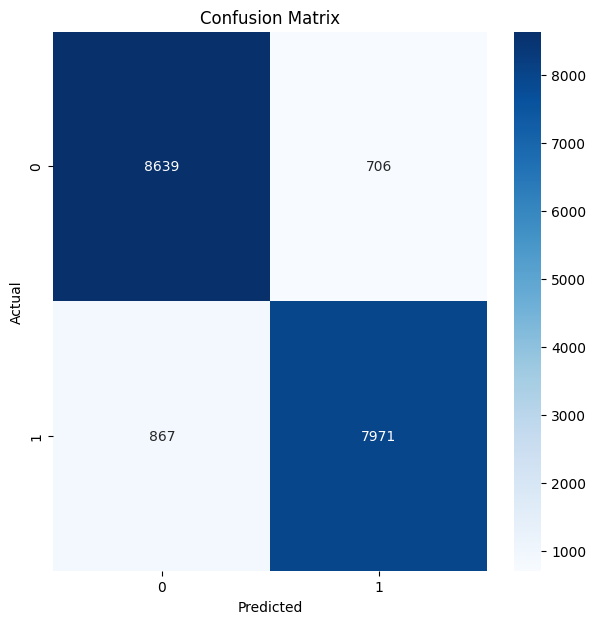

accuracy: 0.9134906231094979
classification report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      9345
           1       0.92      0.90      0.91      8838

    accuracy                           0.91     18183
   macro avg       0.91      0.91      0.91     18183
weighted avg       0.91      0.91      0.91     18183
 


RandomForestClassifier:

train score is 1.0, test score is 0.9004564703294285


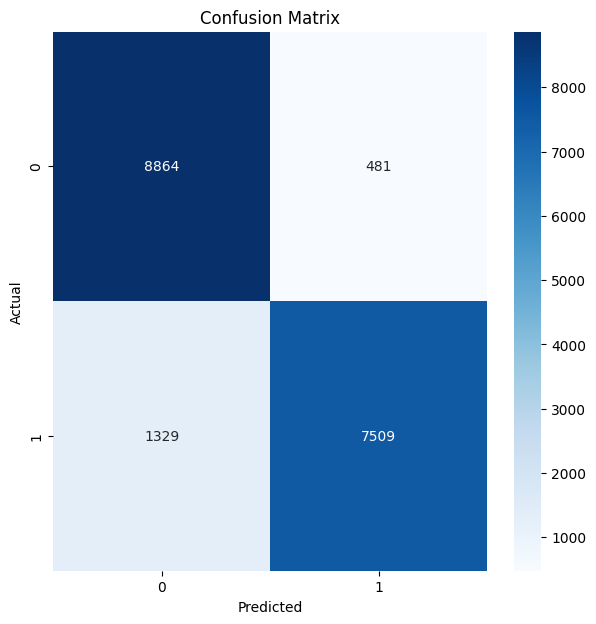

accuracy: 0.9004564703294285
classification report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      9345
           1       0.94      0.85      0.89      8838

    accuracy                           0.90     18183
   macro avg       0.90      0.90      0.90     18183
weighted avg       0.90      0.90      0.90     18183
 


LinearSVC:

train score is 1.0, test score is 0.9284496507726998


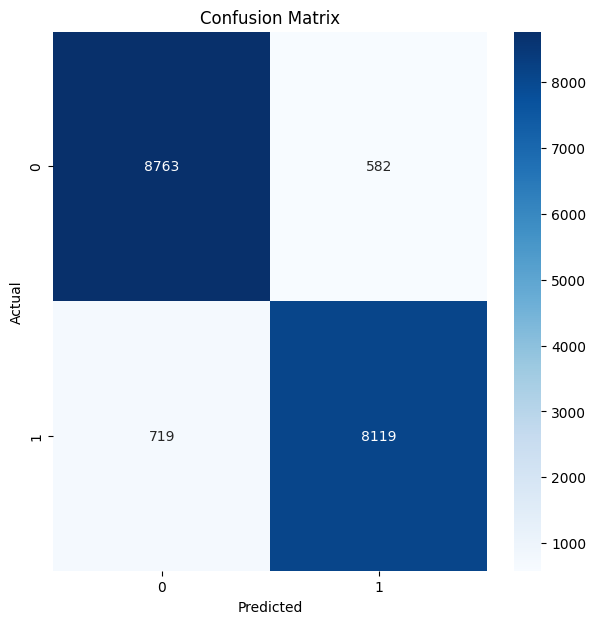

accuracy: 0.9284496507726998
classification report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      9345
           1       0.93      0.92      0.93      8838

    accuracy                           0.93     18183
   macro avg       0.93      0.93      0.93     18183
weighted avg       0.93      0.93      0.93     18183
 


DecisionTreeClassifier:

train score is 1.0, test score is 0.8973766705164165


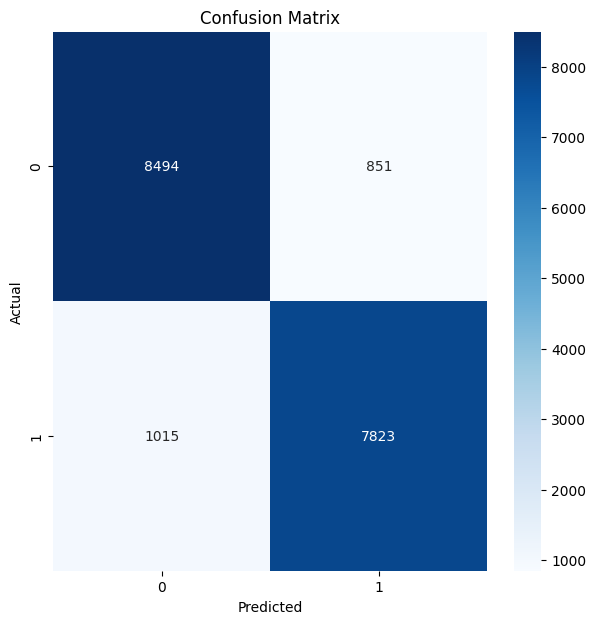

accuracy: 0.8973766705164165
classification report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      9345
           1       0.90      0.89      0.89      8838

    accuracy                           0.90     18183
   macro avg       0.90      0.90      0.90     18183
weighted avg       0.90      0.90      0.90     18183
 


GradientBoostingClassifier:

train score is 0.9841584158415841, test score is 0.9349392289501183


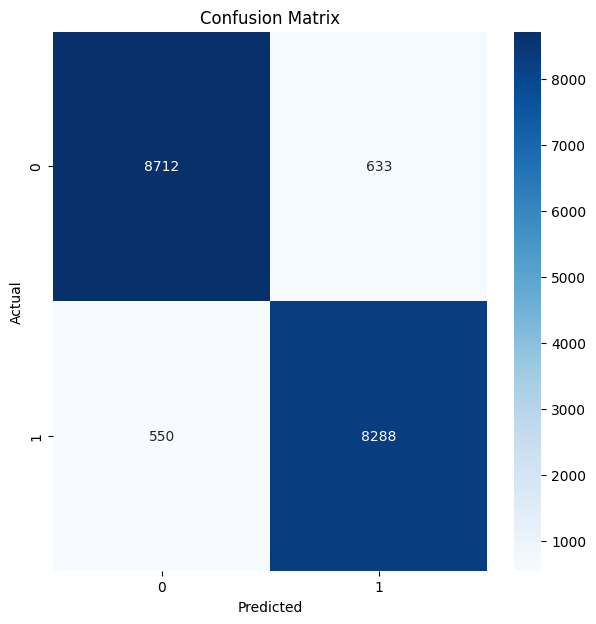

accuracy: 0.9349392289501183
classification report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      9345
           1       0.93      0.94      0.93      8838

    accuracy                           0.93     18183
   macro avg       0.93      0.94      0.93     18183
weighted avg       0.93      0.93      0.93     18183
 




In [26]:
trained_models = {}
for name, model in models.items():
    print(f'{name}:\n')
    model = fit_predict(model, X_train_vectorized, y_train, X_test_vectorized, y_test)
    trained_models[name] = deepcopy(model)

# Save best model

Based on the previous results, the Gradient Boosting Classifier model is the best one on the test data with accuracy 94%.

In [27]:
# Access Gradient Boosting Classifier model
GradientBoostingClassifier_model = trained_models['GradientBoostingClassifier']
GradientBoostingClassifier_model

GradientBoostingClassifier()

In [28]:
# File paths
model_path = 'Prepare_model\GradientBoostingClassifier_model.sav'
vectorizer_path = 'Prepare_model\TfidfVectorizer.sav'

# Save the Gradient Boosting Classifier model using joblib if not already saved
if not os.path.exists(model_path):
    joblib.dump(GradientBoostingClassifier_model, model_path)

# Save the TfidfVectorizer using joblib if not already saved
if not os.path.exists(vectorizer_path):
    joblib.dump(vectorizer, vectorizer_path)

['TfidfVectorizer.sav']

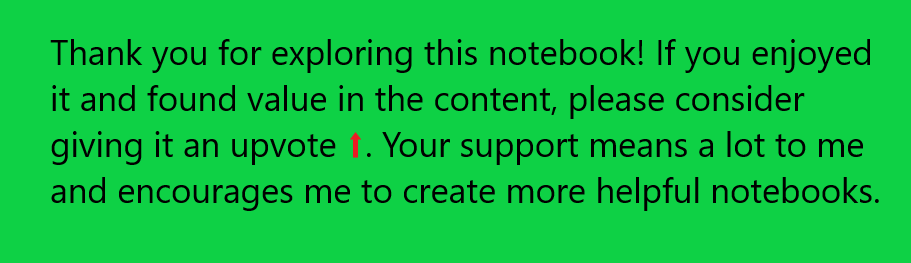